# Machine Learning LAB 2: Perceptrons

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **PERCEPTRON**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Classification of Stayed/Churned Customers

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. Companies are naturally interested in churn, i.e., in which users are likely to switch to another company soon to get a better deal, and which are more loyal customers.

The dataset contains three features:
- **Tenure in Months**: Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age

The aim of the task is to predict if a customer will churn or not based on the three features.

---

## Import all the necessary Python libraries and load the dataset

### The Dataset
The dataset is a `.csv` file containing three input features and a label. Here is an example of the first 4 rows of the dataset: 

<center>

Tenure in Months | Monthly Charge | Age | Customer Status |
| -----------------| ---------------|-----|-----------------|
| 9 | 65.6 | 37 | 0 |
| 9 | -4.0 | 46 | 0 |
| 4 | 73.9 | 50 | 1 |
| ... | ... | ... | ... |

</center>

Customer Status is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [1]:
import numpy as np
import random as rnd
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(42)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    #permute the data
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffle the data
    X = data_train.iloc[:, 0:3].values # Get first two columns as the input
    Y = data_train.iloc[:, 3].values # Get the third column as the label
    Y = 2*Y-1 # Make sure labels are -1 or 1 (0 --> -1, 1 --> 1)
    return X,Y

# Load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

We are going to differentiate (classify) between **class "1" (churned)** and **class "-1" (stayed)**

## Divide the data into training and test sets

In [2]:
# Compute the splits
m_training = int(0.75*X.shape[0])

# m_test is the number of samples in the test set (total-training)
m_test =  X.shape[0] - m_training
X_training =  X[:m_training]
Y_training =  Y[:m_training]
X_test =   X[m_training:]
Y_test =  Y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("Number of churned users in test:", np.sum(Y_test==-1))
print("Number of loyal users in test:", np.sum(Y_test==1))

# Standardize the input matrix
# The transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test =  scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 2817
Number of samples in the test set: 940
Number of churned users in test: 465
Number of loyal users in test: 475
Mean of the training input data: [ 0. -0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [ 0.0134851   0.04850383 -0.0433016 ]
Std of the test input data: [1.00014294 1.00683022 1.02078989]


We will use **homogeneous coordinates** to describe all the coefficients of the model.

_Hint:_ The conversion can be performed with the function $hstack$ in $numpy$.

In [3]:
def to_homogeneous(X_training, X_test):
    # TODO: Transform the input into homogeneous coordinates
    Xh_training = np.hstack((np.ones(shape = (X_training.shape[0], 1)), X_training))
    Xh_test = np.hstack((np.ones(shape = (X_test.shape[0], 1)), X_test))
    return Xh_training, Xh_test

In [4]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.          1.2361321   0.87798477 -0.16001986]
 [ 1.          0.10884685  0.4417593   1.37363294]
 [ 1.          1.69539647 -1.57223186 -0.04204657]
 [ 1.          0.15059816 -0.93544295  0.84275312]
 [ 1.          0.56811122 -0.38890759 -0.57292638]
 [ 1.         -0.39216881 -1.41010975 -0.39596645]
 [ 1.         -1.0184384  -1.53880462 -1.04481955]
 [ 1.         -0.35041751 -0.71649454  0.72477983]
 [ 1.         -1.18544362 -1.45857925  0.4298466 ]
 [ 1.          1.44488863 -1.4385229  -0.16001986]]


## Deterministic perceptron

Now **complete** the function *perceptron*. <br>
The **perceptron** algorithm **does not terminate** if the **data** is not **linearly separable**, therefore your implementation should **terminate** if it **reached the termination** condition seen in class **or** if a **maximum number of iterations** have already been run, where one **iteration** corresponds to **one update of the perceptron weights**. In case the **termination** is reached **because** the **maximum** number of **iterations** have been completed, the implementation should **return the best model** seen throughout.

The current version of the perceptron is **deterministic**: we use a fixed rule to decide which sample should be considered (e.g., the one with the lowest index).

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model (or the latest, if the termination condition is reached)
- $best\_error$: the *fraction* of misclassified samples for the best model

In [5]:
def count_errors(current_w, X, Y):
    # This function:
    # -computes the number of misclassified samples
    # -returns the indexes of all misclassified samples
    # -if there are no misclassified samples, returns -1 as index
    # TODO: write the function
    missclass_mask = np.array([(np.dot(X[i,:], current_w)*Y[i] <= 0) for i in range(X.shape[0])])
    n = np.sum(missclass_mask)
    index = -1
    if n > 0:
        index = np.where(missclass_mask == True)[0][0]
    return n, index

    
def perceptron_fixed_update(current_w, X, Y):
    # TODO: write the perceptron update function
    n, index = count_errors(current_w, X, Y)
    if (n == 0):
        new_w = current_w
    else:
        x, y = X[index, :], Y[index]
        new_w = current_w + x * y
    return new_w

def perceptron_no_randomization(X, Y, max_num_iterations):
    # TODO: write the perceptron main loop
    # The perceptron should run for up to max_num_iterations, or stop if it finds a solution with ERM=0
    best_error = 10e9
    n_iter = 0
    w = np.zeros(X.shape[1])
    while (best_error > 0 and n_iter < max_num_iterations):
        n_iter += 1
        w = perceptron_fixed_update(w, X, Y)
        n , _ = count_errors(w, X, Y)
        error = n/X.shape[0]
        #print("Current error: " + str(n))
        if  error < best_error:
            best_w = w
            best_error = error
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 30 iterations and print the error of the best model we have found.

In [6]:
w_found, error = perceptron_no_randomization(X_training,Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error))
w_found2, error2 = perceptron_no_randomization(X_training,Y_training, 100)
print("Training Error of perceptron (100 iterations): " + str(error2))

Training Error of perceptron (30 iterations): 0.24565140220092296
Training Error of perceptron (100 iterations): 0.24565140220092296


Now use the best model $w\_found$ to **predict the labels for the test dataset** and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [82]:
def loss_estimate(w,X,Y):
    # TODO Estimate the test loss
    n, _ = count_errors(w, X, Y)
    t_loss_estimate = n / X.shape[0]
    return t_loss_estimate


true_loss_estimate =  loss_estimate(w_found, X_test, Y_test)       # Error rate on the test set
true_loss_estimate2 =  loss_estimate(w_found2, X_test, Y_test) 
    
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate2))

Test Error of perceptron (30 iterations): 0.25
Test Error of perceptron (100 iterations): 0.25


### Randomized perceptron

Implement the correct randomized version of the perceptron such that at each iteration the algorithm picks a random misclassified sample and updates the weights using that sample. The functions will be very similar, except for some minor details.

In [83]:
def perceptron_randomized_update(current_w, X, Y):
    # TODO: write the perceptron update function
    missclass_mask = np.array([(np.dot(X[i,:], current_w)*Y[i] <= 0) for i in range(X.shape[0])])
    if np.any(missclass_mask) > 0:
        index = np.random.choice(a = np.where(missclass_mask == True)[0], size = 1)[0]
        new_w = current_w + X[index, :] * Y[index]
    else:
        new_w = current_w
    return new_w

def perceptron_with_randomization(X, Y, max_num_iterations):
    # TODO: write the perceptron main loop
    # The perceptron should run for up to max_num_iterations, or stop if it finds a solution with ERM=0
    best_error = 10e9
    n_iter = 0
    w = np.zeros(X.shape[1])
    while (best_error > 0 and n_iter < max_num_iterations):
        n_iter += 1
        w = perceptron_randomized_update(w, X, Y)
        n , _ = count_errors(w, X, Y)
        error = n/X.shape[0]
        if error < best_error:
            best_w = w
            best_error = error
    return best_w, best_error

Now test the correct version of the perceptron using 30 iterations and print the error of the best model we have found.

In [84]:
# Now run the perceptron for 30 iterations
w_found, error = perceptron_with_randomization(X_training, Y_training, 30)
w_found2, error2 = perceptron_with_randomization(X_training, Y_training, 100)
print("Training Error of perceptron (30 iterations): " + str(error))
print("Training Error of perceptron (100 iterations): " + str(error2))

true_loss_estimate =  loss_estimate(w_found, X_test, Y_test)       # Error rate on the test set
true_loss_estimate2 =  loss_estimate(w_found2, X_test, Y_test) 

print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate2))

Training Error of perceptron (30 iterations): 0.2452964146254881
Training Error of perceptron (100 iterations): 0.24884629037983672
Test Error of perceptron (30 iterations): 0.2542553191489362
Test Error of perceptron (100 iterations): 0.2521276595744681


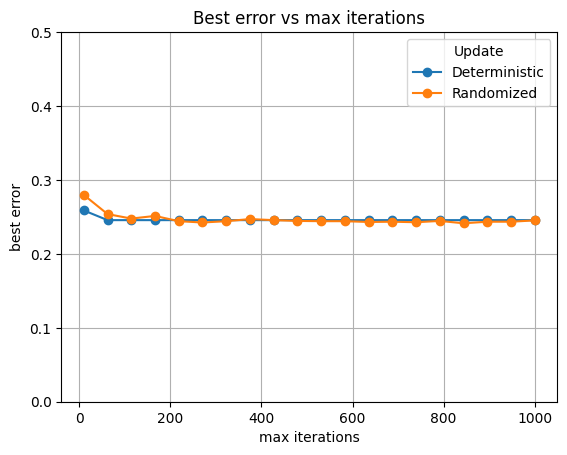

In [ ]:
# TODO Plot the loss with respect to the number of iterations (up to 1000)

errors_no_randomization = []
errors_with_randomization = []

n_iterations = np.linspace(10, 1000, 20)
for n_iter in n_iterations:
    _, error = perceptron_no_randomization(X_training, Y_training, n_iter)
    errors_no_randomization.append(error)
    _, error = perceptron_with_randomization(X_training, Y_training, n_iter)
    errors_with_randomization.append(error)

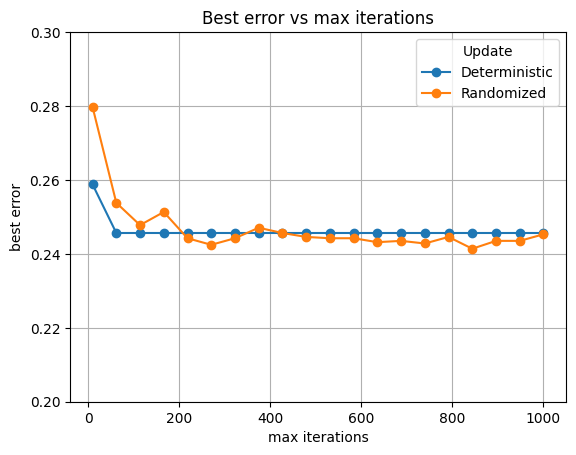

In [89]:
fig, ax = plt.subplots()
ax.plot(n_iterations, errors_no_randomization, marker = "o", label = "Deterministic")
ax.plot(n_iterations, errors_with_randomization, marker = "o", label = "Randomized")
ax.legend(title = "Update")
ax.set_title("Best error vs max iterations")
ax.set_xlabel("max iterations")
ax.set_ylabel("best error")
plt.ylim((0.2, 0.3))
plt.grid()
plt.show()